<h1 align="center" style="font-family:Times,serif">Food Review Classification</h1>


### Problem Description

#### Food Riviews Classification
#### Dataset : https://www.kaggle.com/snap/amazon-fine-food-reviews

### Import Packages

In [1]:
#!pip install -r requirements.txt
#!pip install -U gensim
# Add environment Packages paths to conda
import os, sys
# env_name = "food_review"
# sys.path.append(f"C:\\Environments\\{env_name}\\lib\\site-packages\\")

import pandas as pd
import numpy as np

# Text preprocessing packages
import nltk # Text libarary
#nltk.download('stopwords')
#nltk.download('wordnet')
import string # Removing special characters {#, @, ...}
import re # Regex Package
from nltk.corpus import stopwords # Stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer # Stemmer & Lemmatizer
from gensim.utils import simple_preprocess  # Text ==> List of Tokens

# Text Embedding
from sklearn.feature_extraction.text import TfidfVectorizer

# Modelling
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Saving Model
import pickle

# Visualization Packages
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1.3)
%matplotlib inline

C:\Users\hazem\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


### Read Dataset

In [2]:
%%time
df = pd.read_csv('Reviews.csv')

Wall time: 3.98 s


In [3]:
f"{df.shape[0]:,} Review"

'568,454 Review'

In [4]:
cols = ['Text', 'Score']
df_text = df[cols].copy()
df_text.head()

,Text,Score
0,I have bought several of the Vitality canned d...,5
1,Product arrived labeled as Jumbo Salted Peanut...,1
2,This is a confection that has been around a fe...,4
3,If you are looking for the secret ingredient i...,2
4,Great taffy at a great price. There was a wid...,5


### Drop Duplicates
Save the Cleaned data-frame also with the variable `df_text`

In [5]:
df_text.drop_duplicates(inplace=True)
df_text.reset_index(drop=True,inplace=True)

### Target Variable Pre-Processing
`target` will be 
 - 0 if score < 3 
 - 1 otherwise

In [6]:
df_text['target'] = df_text['Score'].apply(lambda x: 0 if x <3 else 1)

#### Plot Countplot for target Variable

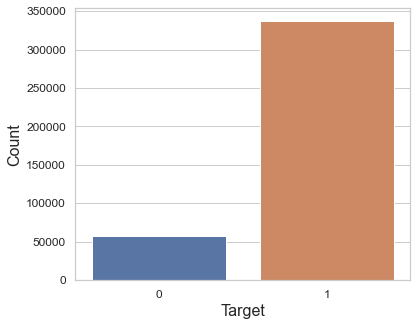

In [7]:
sns.set_style("whitegrid")
x=df_text['target'].value_counts().index
y=df_text['target'].value_counts().values
plt.figure(figsize=(6,5));
sns.barplot(y=y,x=x,orient='v');
plt.xlabel('Target',size=16)
plt.ylabel('Count',size=16)
plt.xticks(size=12);
plt.yticks(size=12);

Notice how such variance is huge ...   
Then we need to down-sample such data ... by which both the positive and negative classes are balanced.

### Balance Data Target

In [8]:
# Sample from positive reviews Same number of negative reviews
NEG_N = df_text.target.value_counts()[0]
df_pos = df_text[df_text['target'] == 1]['Text'].sample(NEG_N, replace=False)
df_text_balanced = pd.concat([df_text.iloc[df_pos.index], df_text[df_text.target == 0]])

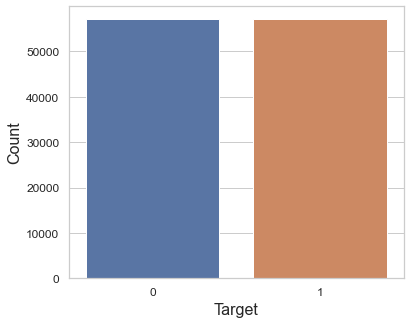

In [9]:
sns.set_style("whitegrid")
x=df_text_balanced['target'].value_counts().index
y=df_text_balanced['target'].value_counts().values
plt.figure(figsize=(6,5));
sns.barplot(y=y,x=x,orient='v');
plt.xlabel('Target',size=16)
plt.ylabel('Count',size=16)
plt.xticks(size=12);
plt.yticks(size=12);

### Text Pre-Processing

In [10]:
punc = string.punctuation
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")
lemmatizer= WordNetLemmatizer()

In [11]:
df_text_balanced.head()

,Text,Score,target
286934,These dental chews are both a great treat for ...,4,1
154260,I recently began a weight loss program and fou...,5,1
156105,Excellent product. Provides all the benefits o...,5,1
110193,Curry has officially become my FAVORITE food o...,5,1
387709,These are sooooooo good. I highly recommend Tr...,5,1


In [12]:
## Clean reviews using stemmer, lemmatizer & stopwords
df_text_balanced['Text'] = df_text_balanced['Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in punc]))
df_text_balanced['Text'] = df_text_balanced['Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
df_text_balanced['Text'] = df_text_balanced['Text'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))
df_text_balanced['Text'] = df_text_balanced['Text'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))
df_text_balanced.head()

,Text,Score,target
286934,these dental chew great treat dog well suppos ...,4,1
154260,i recent began weight loss program found tjmax...,5,1
156105,excel product. provid benefit coconut oil easi...,5,1
110193,curri offici becom favorit food past year. i c...,5,1
387709,these sooooooo good. i high recommend trader j...,5,1


### Split Test & Training Data

In [13]:
X = df_text_balanced['Text']
y = df_text_balanced['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Text Embedding
 - Use `TfidfVectorizer`
 - `fit` on the training data only
 - `transform` on training and test 

In [14]:
## TFIDF embedding for the Description
vectorizer = TfidfVectorizer()
# fit on training (such vectorizer will be saved for deployment)
vectorizer_tfidf = vectorizer.fit(X_train)
# transform on training data
X_train = vectorizer.transform(X_train)
# transform on testing data
X_test = vectorizer.transform(X_test)

In [15]:
# See the dimensions of your data embeddings before entering to the model
X_train.shape, X_test.shape

((79917, 53249), (34251, 53249))

### Modelling

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

##### Sklearn framework steps
 - init
 - fit
 - predict

In [17]:
## initialize your Model
clf = RandomForestClassifier() 
# Fit your Model on the Training Dataset
clf.fit(X_train,y_train)
# Predict on Test data
preds = clf.predict(X_test)
# Calculate Model Accuracy
acc = accuracy_score(preds, y_test)
print(f"Model Accuracy = {round(acc*100,2)}%")

Model Accuracy = 83.89%


### Raw Instance Prediction

In [18]:
def clean(review):
    review= ' '.join([word for word in review.split() if word not in punc])
    review = ' '.join([word for word in review.split() if word not in (stop_words)])
    review = ' '.join([stemmer.stem(word) for word in review.split()])
    review = ' '.join([lemmatizer.lemmatize(word) for word in review.split()])
    return review
    
def raw_test(review, model, vectorizer):
    # Clean Review
    review_c = clean(review)
    # Embed review using tf-idf vectorizer
    embedding = vectorizer.transform([review_c])
    # Predict using your model
    prediction = model.predict(embedding)
    # Return the Sentiment Prediction
    return "Positive" if prediction == 1 else "Negative"

In [19]:
review_1 = "That's a good Dish, Good Job"
review_2 = "That's the worst Dish ever tasted"

In [20]:
raw_test(review_1, clf, vectorizer_tfidf)

'Positive'

In [21]:
raw_test(review_2, clf, vectorizer_tfidf)

'Negative'

### Saving Models for Deployment

In [22]:
import pickle

In [23]:
model_name = 'rf_model.pk'
vectorizer_name = 'tfidf_vectorizer.pk'
model_path = os.path.join('/', model_name)
vect_path = os.path.join('/', vectorizer_name)
pickle.dump(clf, open(model_name, 'wb'))
pickle.dump(vectorizer, open(vectorizer_name, "wb"))

### Load model Again and test them

In [24]:
loaded_model =  pickle.load(open(model_name, 'rb'))
loaded_vect = pickle.load(open(vectorizer_name, 'rb'))

In [25]:
raw_test(review_1, loaded_model, loaded_vect)

'Positive'

In [26]:
raw_test(review_2, loaded_model, loaded_vect)

'Negative'

### Now Deploy your ML model using Streamlit Framework

In [27]:
!streamlit run deploy.py

^C
